# 08: Regressions

* **author** = Diego Sapunar-Opazo
* **copyright** = Copyright 2019, Thesis M.Sc. Diego Sapunar - Pontificia Universidad Católica de Chile
* **credits** = Diego Sapunar-Opazo, Ronald Perez, Mar Perez-Sanagustin, Jorge Maldonado-Mahauad
* **maintainer** = Diego Sapunar-Opazo
* **email** = dasapunar@uc.cl
* **status** = Dev

## Part 0: Packages

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

import statsmodels.formula.api as smf

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Part 2: Variable Importance

In [2]:
df_sec = pd.read_csv('../../data/clean_data/students_sec.csv')
df_clusters = pd.read_csv('../../data/final_data/students_clusters.csv')
df_interactions = pd.read_csv('../../data/final_data/coursera_students_interactions_nueva.csv', low_memory=False)
df_performance = pd.read_csv('../../data/final_data/performance.csv').iloc[:, [0,-1]]
df_clusters = pd.read_csv('../../data/final_data/students_clusters.csv')
df_performance_weekly = pd.read_csv('../../data/final_data/performance_weekly.csv')

In [3]:
df_interactions.interaction.unique()

array(['Assessment try', 'Video-Lecture begin', 'Video-Lecture completed',
       'Video-Lecture review', 'Reading completed', 'Assessment pass',
       'Assessment review', 'Reading review'], dtype=object)

In [4]:
aux_number_interactions = df_interactions[['num_alumno', 'week', 'interaction']].groupby(['num_alumno', 'interaction']).count()
aux_timespent = df_interactions[['num_alumno', 'timespent', 'interaction']].groupby(['num_alumno', 'interaction']).sum()

In [5]:
aux_number_interactions = aux_number_interactions.unstack(level=1).fillna(0).week
aux_number_interactions.drop(['Reading completed', 'Reading review'], axis=1, inplace=True)
aux_number_interactions.reset_index(inplace=True)

_columns_to_rename = {
    'Assessment pass': 'number_interac_asses_pass',
    'Assessment review': 'number_interac_asses_review',
    'Assessment try': 'number_interac_asses_try',
    'Video-Lecture begin': 'number_interac_video_begin',
    'Video-Lecture completed': 'number_interac_video_completed',
    'Video-Lecture review': 'number_interac_video_review',
}
aux_number_interactions.rename(_columns_to_rename, axis=1, inplace=True)

aux_timespent = aux_timespent.unstack(level=1).fillna(0).timespent
aux_timespent.drop(['Reading completed', 'Reading review'], axis=1, inplace=True)
aux_timespent.reset_index(inplace=True)

_columns_to_rename = {
    'Assessment pass': 'ts_asses_pass',
    'Assessment review': 'ts_asses_review',
    'Assessment try': 'ts_asses_try',
    'Video-Lecture begin': 'ts_video_begin',
    'Video-Lecture completed': 'ts_video_completed',
    'Video-Lecture review': 'ts_video_review',
}
aux_timespent.rename(_columns_to_rename, axis=1, inplace=True)



In [6]:
df = pd.merge(left=df_performance, right=aux_number_interactions, left_on='num_alumno', right_on='num_alumno')
df = pd.merge(left=df, right=aux_timespent, left_on='num_alumno', right_on='num_alumno')
df = pd.merge(left=df, right=df_clusters, left_on='num_alumno', right_on='num_alumno')


In [7]:
dummy = pd.get_dummies(df['cluster'])
df = pd.concat([df, dummy], axis=1)
df.rename({0: 'effort', 1: 'prior_knowledge', 2: 'no_effort'}, axis=1, inplace=True)

In [10]:
# Create linear regression object.
mlr= LinearRegression()

feature_cols = [
    'number_interac_asses_pass', 
                'number_interac_asses_review', 
                'number_interac_asses_try', 
                'number_interac_video_begin', 
                'number_interac_video_completed', 
                'number_interac_video_review',
                'ts_asses_pass', 
                'ts_asses_review', 
                'ts_asses_try', 
                'ts_video_begin', 
                'ts_video_completed', 
                'ts_video_review'
#                  'effort', 
#                 'prior_knowledge', 
#                 'no_effort'
]
X = df[feature_cols]

Y = df['NF']

# Fit linear regression.
mlr.fit(X, Y)

# Get the slope and intercept of the line best fit.
print(mlr.intercept_)

# print(mlr.coef_)

# pair the feature names with the coefficients
list(zip(feature_cols, mlr.coef_))


5.201713961536325


[('number_interac_asses_pass', -0.0021850937655115603),
 ('number_interac_asses_review', 4.462693789442359e-06),
 ('number_interac_asses_try', -3.80350365292752e-05),
 ('number_interac_video_begin', 0.00013647562878329144),
 ('number_interac_video_completed', -0.0010960680786605516),
 ('number_interac_video_review', 0.0022952785647808987),
 ('ts_asses_pass', 0.000829445729631698),
 ('ts_asses_review', 8.470164910441102e-06),
 ('ts_asses_try', 5.62514713559186e-06),
 ('ts_video_begin', 8.00824909872126e-06),
 ('ts_video_completed', 1.4492732160866947e-05),
 ('ts_video_review', -4.73652185108192e-05)]

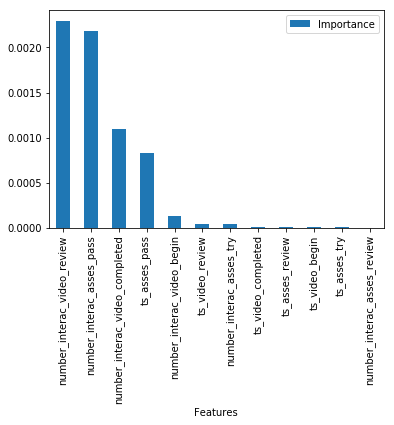

In [11]:
res =  [abs(ele) for ele in list(mlr.coef_)] 
aux = pd.DataFrame({'Features': feature_cols, 'Importance': res}).set_index('Features')
aux.sort_values('Importance', ascending=False, inplace=True)
aux.plot(kind='bar')

In [12]:
### SCIKIT-LEARN ###

# print the R-squared value for the model
mlr.score(X, Y)

0.15508076385729097

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

# Instantiate model
lm2 = LinearRegression()

# Fit Model
lm2.fit(X_train, y_train)

# Predict
y_pred = lm2.predict(X_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.5259093595850967


## Part 3: Prediction Alert